Diego Colón

Exam 3 - Solution

November 20, 2020


In [99]:
# Import necessary libraries
import control
import numpy as np
from math import e
from scipy.signal import *
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [100]:
# Required code for loop shaping
class Design():
    def __init__(self,tf,name=None):
        self.tf = tf
        self.name = name

class Analyze():
    def __init__(self,System):
        self.L= [System]
        self.CL = None

    def addDesign(self,cont):
        num = np.poly1d(self.L[-1].tf.num)* np.poly1d(cont.tf.num)
        den = np.poly1d(self.L[-1].tf.den)* np.poly1d(cont.tf.den)
        self.L.append(Design(TransferFunction(num,den),name=cont.name))

    def removeDesign(self):
        del self.L[-1]
    
    def replaceDesign(self,cont):
        num = np.poly1d(self.L[-2].tf.num)* np.poly1d(cont.tf.num)
        den = np.poly1d(self.L[-2].tf.den)* np.poly1d(cont.tf.den)
        self.L[-1] = (Design(TransferFunction(num,den),name=cont.name))

    def ClosedLoop(self):
        CLn = np.poly1d(self.L[-1].tf.num)
        CLd = np.poly1d(self.L[-1].tf.num)+np.poly1d(self.L[-1].tf.den)
        self.CL = TransferFunction(CLn.c,CLd.c)
    
    def Magnitude(self,w,CL=False):
        j = 0 + 1j
        if CL:
            self.ClosedLoop()
            L_num = np.poly1d(self.CL.num)
            L_den = np.poly1d(self.CL.den)
        else:
            L_num = np.poly1d(self.L[-1].tf.num)
            L_den = np.poly1d(self.L[-1].tf.den)
        H = L_num(j*w)/L_den(j*w)
        return 20*np.log10(np.linalg.norm([H.real,H.imag]))

    def Phase (self,w,CL=False):
        j = 0 + 1j
        if CL:
            self.ClosedLoop()
            L_num = np.poly1d(self.CL.num)
            L_den = np.poly1d(self.CL.den)
        else:
            L_num = np.poly1d(self.L[-1].tf.num)
            L_den = np.poly1d(self.L[-1].tf.den)
        H = L_num(j*w)/L_den(j*w)
        #return np.angle(H)
        return np.arctan(H.imag/H.real)
        
    def TDM(self,CL=False):
        res = fsolve(self.Magnitude,10,args=CL)
        w_gc = res[0]
        return (self.Phase(w_gc,CL=CL))/w_gc, w_gc

    def Bode(self,CL=False):
        if CL:
            self.ClosedLoop()
            ω, m, ϕ = self.CL.bode(np.linspace(10e-2,10e2,num=int(10e4)))
            plt.figure(1)
            plt.semilogx(ω,m,label="Closed Loop")

            plt.figure(2)
            plt.semilogx(ω,ϕ,label="Closed Loop")
            
        else:
            for l in self.L:
                ω, m, ϕ = l.tf.bode(np.linspace(10e-2,10e2,num=int(10e4)))

                plt.figure(1)
                plt.semilogx(ω,m,label=l.name)

                plt.figure(2)
                plt.semilogx(ω,ϕ,label=l.name)

        plt.figure(1)
        plt.title("Bode Magnitude Plot")
        plt.xlabel("w - [rad/s]")
        plt.ylabel("M - [dB]")
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.legend()

        plt.figure(2)
        plt.title("Bode Phase Plot")
        plt.xlabel("w - [rad/s]")
        plt.ylabel("phi - [deg]")
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.legend()

        if display:
            plt.show()

# Question 1

## A) 

Assume that you performed a sine-sweep experiment on an singleloop  series  RLC  circuit  with  voltage  as  the  input  and  current  as  the  output  and  got  the following results: 

$\omega  = [0.01,0.1,1,10,100,1000][\frac{rad}{s}]$, $I  = [10,10,10,1,0.1,0.01][A]$

Design a controller so that the bandwidth of the closed-loop is approximately 50 $[\frac{rad}{s}]$

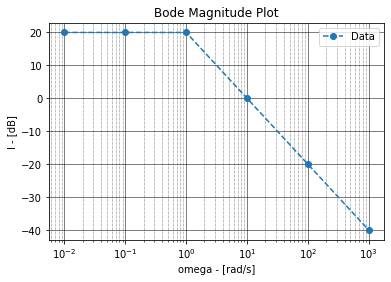

In [101]:
# Create data arrays
omega = np.array([0.01,0.1,1,10,100,1000])
I = np.array([10,10,10,1,0.1,0.01])

# Find the magnitude in [dB]
I_db = 20*np.log10(I)

# Plot the bode magnitude plot
plt.figure(1)
plt.semilogx(omega,I_db,"o--",label="Data")
plt.title("Bode Magnitude Plot")
plt.xlabel("omega - [rad/s]")
plt.ylabel("I - [dB]")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend()
plt.show()

Based on the shape of the data, it can be expected that the RLC circuit can be modeled as a first order system with a transfer function of the type 

$$I(s) = G_{DC}\frac{\omega_{0}}{s+\omega_{0}}$$

where:

$$G_{DC} = 10^{\frac{20}{20}} = 10$$

$\omega_{0}$ is the frequency where there is a loss of -3$[dB]$, meaning $\omega_{0} = \frac{23}{20} [\frac{rad}{s}] = 1.15 [\frac{rad}{s}] $

Leaving the system transfer fucntion to be $I(s) = 10\frac{1.15}{s + 1.15}$


From the bode plot above it can be seen that the bandwidth, which is approximately equal to $\omega_{gc}$, is 10 $[\frac{rad}{s}]$. This means that  $\omega_{gc}$ must increase by approximately a factor of 5. To do this, the loop shaping method will be used through the python functions in the beginning of this document.

The figures below show that although the identified transfer function is close to the measured model, they are not the same. This is to be expected when measuring a system and estimating its parameters. 

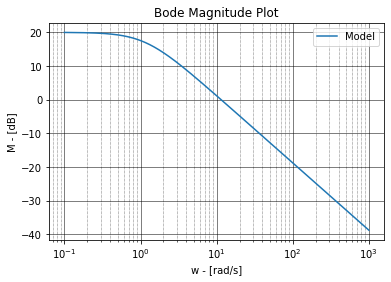

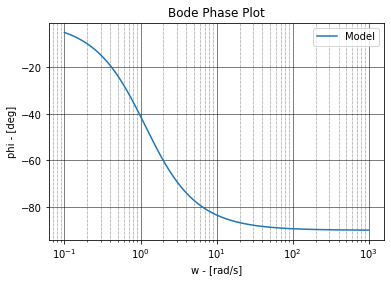

In [102]:
model = Design(TransferFunction([10*1.15],[1,1.15]),name="Model")
Loop1 = Analyze(model)
Loop1.Bode()

Since the objective is to make a controller so that the bandwidth of the closed-loop is approximately 50 $[\frac{rad}{s}]$, the reciprocal of the time constant for the transfer function must be around 50. Using a proportional controller could achieve this:

$$ H_{IV_S} = \frac{C{_p}I}{1 + C{_p}I} =10 \frac{1.15K_p}{s + 11.5K_p + 1.15}$$

leads to $11.5K_p \approx 11.5K_p + 1.15 \approx 50 $

Solving the expressing above, $K_p \in [\frac{977}{230},\frac{100}{23}] $

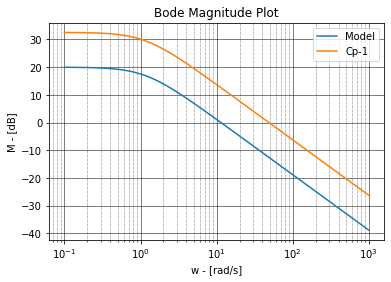

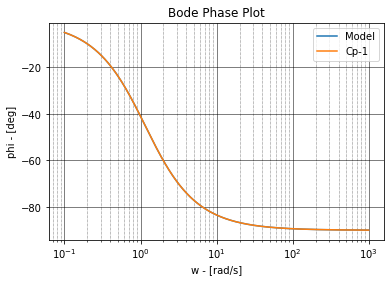

In [103]:
Cp_1 = Design(TransferFunction([977/230],[1]),name="Cp-1")
Loop1.addDesign(Cp_1)
Loop1.Bode()

Checking the stability of this closed loop system shows that the controller is stable


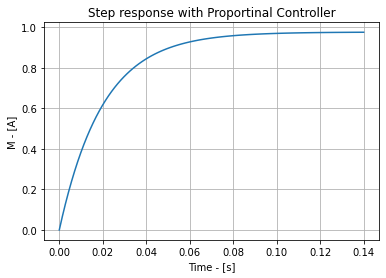

In [104]:
Loop1.ClosedLoop()

t, y = step(Loop1.CL)
plt.plot(t, y)
plt.xlabel('Time - [s]')
plt.ylabel('M - [A]')
plt.title('Step response with Proportinal Controller')
plt.grid()
plt.show()

## (Bonus)

Based on the availabe information, can you tell what the capacitance of the circuit is?

Applying KVL to series RLC circuit:

$$ v_S = v_R + v_C + v_L $$

Substituting the relationships ($v_R = iR$, $v_C = \frac{1}{C}\int_{ }^{ }idt$ and, $v_L = L\frac{di}{dt}$) and taking a time derivative

$$ \frac{dv_s}{dt} = R\frac{di}{dt} + \frac{1}{C}i +  L\frac{di^2}{dt^2} $$

For the order of the system to be reduced to a first order, and match the data from the bode plot, the capacitance must be very large.

$$ \lim_{C \to +\infty} (\frac{dv_s}{dt}) = \lim_{C \to +\infty} ( R\frac{di}{dt} + \frac{1}{C}i +  L\frac{di^2}{dt^2}) =  R\frac{di}{dt} +  L\frac{di^2}{dt^2} $$

Integrating the system once, rearranging to place in standard form and getting the transfer function:

$$\frac{I}{V_S}(s) = \frac{\frac{1}{L}}{s + \frac{R}{L}}$$

In conclusion, the value for the capacitance must be very large for system to behave like a first order system.




# Question 2) 

For the inverted Pendulum $P(s) = \frac{10}{s^2 + 2s -7}$:


## A) Calculate the time delay margin of the closed loop under the proportional controller with $K_p = 1$.

The general equation for the the closed-loop transfer function of the pendulum under a proportional controller is given by:

$$C_p P(s) = \frac{10K_p}{s^2 +2s + (10K_p -7)}$$

with the magnitude, phase and time delay margins being:

$$m = |C_pP(s)|_{dB} = 20log_{10}(|\frac{10K_p}{s^2 +2s + (10K_p -7)}|)$$

$$\phi = \angle C_p P(s) = \arctan(\frac{\Im(C_p P(s))}{\Re(C_p P(s))})$$

$$t_{d} = \frac{\phi}{\omega_{gc}}; \omega_{gc} \ni m = 0$$

Using the equations above and a root finding algorithm, $\omega_{gc}$ is found and from there the Time delay margin is computed.

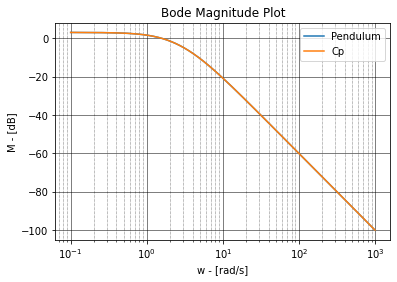

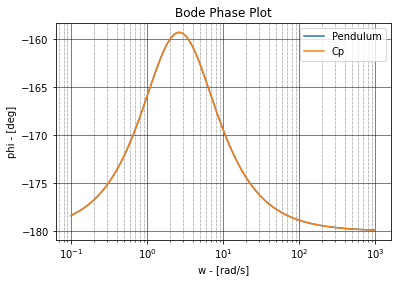

Time delay = 0.203 [s] @ w_gc = -1.578 [rad/s]


In [105]:
P = TransferFunction([10],[1,2,-7])
Pendulum = Design(P,name="Pendulum")
Loop2 = Analyze(Pendulum)
Cp = Design(TransferFunction([1],[1]),name="Cp")
Loop2.addDesign(Cp)
td = Loop2.TDM()
Loop2.Bode()
print("Time delay = {:.3f} [s] @ w_gc = {:.3f} [rad/s]".format(td[0], td[1]))

## B) What  is  the  maximum  possible  time  delay  margin  you  can  get  using  a proportional controller while keeping the closed loop BIBO stable?

The Routh criteria for a second order system states all coefficients of the characteristic polynomial must be of the same sign. This restricts the possible values of $K_p$ to $K_p \in (\frac{7}{10}, \infty)$

Below, the Time delay margin is calculated for different values of $K_p$ and plotted

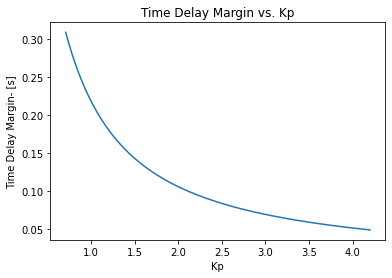

The largest achievable t_d = 0.309 [s] @ w_gc = 2.323 [rad/s] with kp = 0.707


In [106]:

I = np.linspace(1,500,num=500)
k = []
t_d = []
w_gc = []

for i in I:
    kp = (7/10)*(1 + i/100)
    C_tests = Design(TransferFunction([kp],[1]))
    Loop2.replaceDesign(C_tests)
    t, w = Loop2.TDM(CL=True)
    k.append(kp)
    t_d.append(t)
    w_gc.append(abs(w))

plt.figure(1)
plt.title("Time Delay Margin vs. Kp")
plt.plot(k,t_d)
plt.xlabel("Kp")
plt.ylabel("Time Delay Margin- [s]")
plt.show()

r = np.argmax(t_d)
print("The largest achievable t_d = {:.3f} [s] @ w_gc = {:.3f} [rad/s] with kp = {:.3f}".format(t_d[r],abs(w_gc[r]),k[r]))

## C) Design a controller such that the time delay margin of the closed loop is at least 0.35 s.

From the plot above, it can be seen that a proportional will not provide the required $t_d$. In order to increase $t_d$ one could either: 1) increase $\phi$ while keeping $\omega_{gc}$ relatively constant, or 2) decrease $\omega_{gc}$ while keeping $\phi$ relatively constant. For this controller option one will be implemented because option two reduces the bandwidth of the system.

To increase $\phi$ while keeping $\omega_{gc}$ relatively constant, a lead compensator of the form 
$C_{lead}(s) = M( \frac{s + \frac{\omega_{lead}}{\sqrt{M}}}{s + \omega_{lead}\sqrt{M}})$ where:

$M = \frac{1 + \sin(\phi_{lead})}{1 - \sin(\phi_{lead})}$ is the gain of the compensator in linear units

$\omega_{lead}$ is the frequency at which the phase peak occurs and,

$\phi_{lead}$ is the phase magnitude of the peak.


To satisfy the $t_d$ requirement of being greater than 0.35 $[s]$, the closed-loop transfer function should have a phase margin greater than 65 $[deg]$ at a similar $\omega_{gc}$ of the closed-loop transfer function with a proportional controller of one. Meaning that $\phi_{lead} \geq \frac{4\pi}{45}$ at $\omega_{lead} = 3.75$.

From these parameters, the controller comes out to be

$C_{lead}(s) = ( \frac{1.761s + 4.318}{s + 0.4078})$

Below are the equations for the magnitude, phase and time delay margin for a general closed loop function

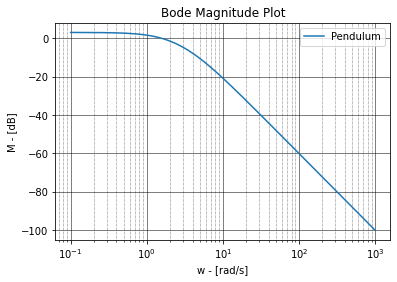

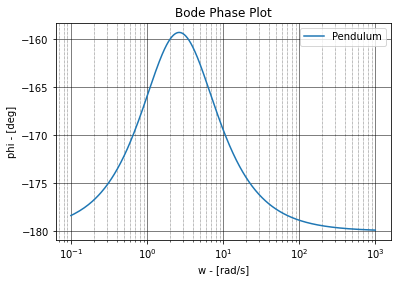

Time delay = 0.203 [s] @ w_gc = 1.578 [rad/s]


In [107]:
Loop2.removeDesign()
td = Loop2.TDM()
Loop2.Bode()
print("Time delay = {:.3f} [s] @ w_gc = {:.3f} [rad/s]".format(td[0], abs(td[1])))

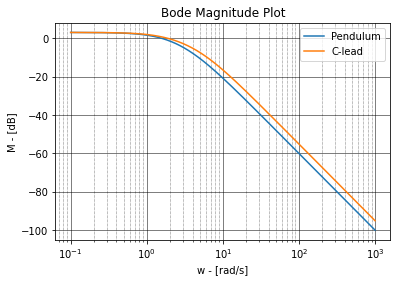

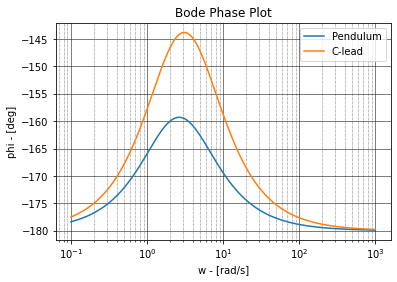

Time delay = 0.301 [s] @ w_gc = 1.896 [rad/s]


In [108]:
phi_lead = 4*np.pi/45
M = (1 + np.sin(phi_lead))/(1 - np.sin(phi_lead))
omega_lead = 3.75

Clead_1 = Design(TransferFunction([M,omega_lead*np.sqrt(M)],[1,omega_lead*np.sqrt(M)]),name="C-lead")
Loop2.addDesign(Clead_1)
td = Loop2.TDM()
Loop2.Bode()
print("Time delay = {:.3f} [s] @ w_gc = {:.3f} [rad/s]".format(td[0], abs(td[1])))

Since the time delay margin is not above the required value, an iterative process is used to get the required value. 

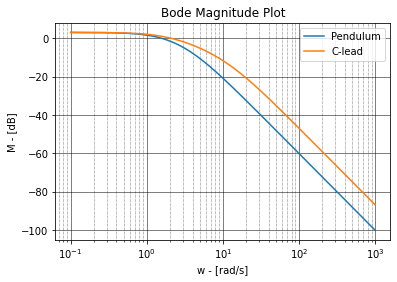

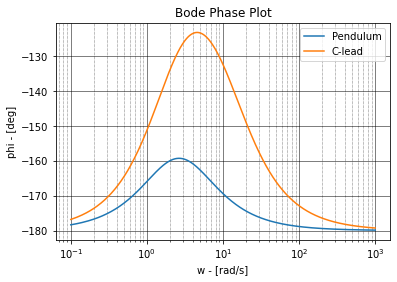

Time delay = 0.391 [s] @ w_gc = 2.107 [rad/s]


In [109]:
phi_lead = np.deg2rad(40)
M = (1 + np.sin(phi_lead))/(1 - np.sin(phi_lead))
omega_lead = 6.25

Clead_2 = Design(TransferFunction([M,omega_lead*np.sqrt(M)],[1,omega_lead*np.sqrt(M)]),name="C-lead")
Loop2.replaceDesign(Clead_2)
td = Loop2.TDM()
Loop2.Bode()
print("Time delay = {:.3f} [s] @ w_gc = {:.3f} [rad/s]".format(td[0], abs(td[1])))

## D) Test your controller under delay and provide the step response plots for a delay of 0.34s.  Is the behavior of the system as expected?  If not, why not?

For the step response with a delay, Matlab was used because the control and signal libraries do not support deadbands. Below is the plot generated by matlab. It can be seen that the system is just barely stable. This is due to the time delay being just shy of the available margin. Overall the system behaves as expected.


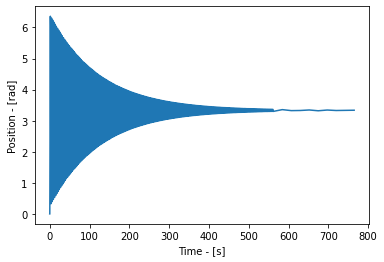

In [110]:
t,y = np.loadtxt('D.csv', delimiter=',', unpack=True)
plt.plot(t,y,label='Delay = 0.34')
plt.xlabel("Time - [s]")
plt.ylabel("Position - [rad]")
plt.legend()
plt.show()

## E) Using the same code as above, provide the step response plots for a delaythat is larger than the time delay margin of the closed loop corresponding to your final design.  Is the behavior of the system as expected?  If not, why not? 

For a time delay just barely larger than the time delay margin, the system becomes unstable. This was expected and verified through the simulation.

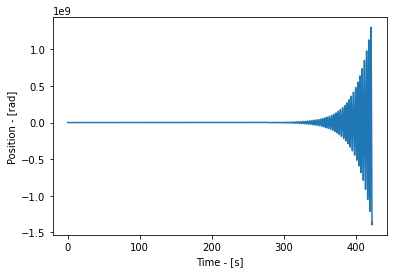

In [111]:
t,y = np.loadtxt('E.csv', delimiter=',', unpack=True)
plt.plot(t,y,label='Delay = 0.4')
plt.xlabel("Time - [s]")
plt.ylabel("Position - [rad]")
plt.show()